## Conditional GAN to Generate Plant Disease Images

To use a Conditional Generative Adversarial Network (cGAN) to generate variant images based on existing images, you can follow these steps. cGANs are an extension of GANs where additional information (like a label or image) is provided as input to both the generator and discriminator, allowing you to generate controlled variations.

**Overview of cGAN**
- Generator (G): Takes random noise (z) along with a condition (c) and generates an image (G(z, c)).
- Discriminator (D): Takes an image and a condition and tries to determine if the image is real or fake.

**Network Architecture:**
- Generator: The generator should take an existing image and a random noise vector as input to produce a new variant of that image. You can concatenate the image with the noise and pass it through a series of convolutional layers.
- Discriminator: The discriminator will take an input image (either real or generated) and a conditional input (the original image or variant label). It will then output a probability indicating whether the input image is real or fake.

**Conditional Input:**
- In cGAN, both the Generator and Discriminator are conditioned on some information. For image-to-image translation, the conditioning is usually done using the original image.
- The Generator receives an image (x) and noise (z) and outputs a new variant (G(x, z)).
- The Discriminator receives an image pair (original, generated) or (original, real) and outputs whether it thinks the generated image is real or fake.

**Model Training:**
- Discriminator Training:
    - Train the discriminator on real pairs (original image, real variant) and label them as real (1).
    - Train the discriminator on generated pairs (original image, G(x, z)) and label them as fake (0).
- Generator Training:
    - Train the generator to create convincing variants of the input image such that the discriminator classifies them as real. The loss function of the generator should encourage it to fool the discriminator.
    - Use a BCE (Binary Cross-Entropy) loss for both the generator and discriminator.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt

## cGAN Architecture

In [2]:
class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim=100, output_channels=3, feature_maps=128):
        super(ConditionalGenerator, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            # Input: (input_dim) -> Output: (feature_maps * 16) x 4 x 4
            nn.ConvTranspose2d(self.input_dim, feature_maps * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps * 16),
            nn.ReLU(True),

            # State: (feature_maps * 16) x 4 x 4 -> (feature_maps * 8) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 16, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            # State: (feature_maps * 8) x 8 x 8 -> (feature_maps * 4) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            # State: (feature_maps * 4) x 16 x 16 -> (feature_maps * 2) x 32 x 32
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            # State: (feature_maps * 2) x 32 x 32 -> (feature_maps) x 64 x 64
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # State: (feature_maps) x 64 x 64 -> (output_channels) x 128 x 128
            nn.ConvTranspose2d(feature_maps, output_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3, feature_maps=128):  # Increased feature maps
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: (input_channels) x 128 x 128 -> Output: (feature_maps) x 64 x 64
            nn.Conv2d(input_channels, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps) x 64 x 64 -> (feature_maps * 2) x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 2) x 32 x 32 -> (feature_maps * 4) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 4) x 16 x 16 -> (feature_maps * 8) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 8) x 8 x 8 -> (feature_maps * 16) x 4 x 4
            nn.Conv2d(feature_maps * 8, feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 16) x 4 x 4 -> Output: 1
            nn.Conv2d(feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Binary classification: real or fake
        )

    def forward(self, img):
        return self.model(img)

## Hyperparamters

In [3]:
# Instantiate three Conditional Generators for each class
input_dim = 256  # Typically the size of random noise vector
output_channels = 3  # RGB images
feature_maps = 64  # Number of feature maps (can be adjusted based on preference)

classes = ['Healthy', 'Powdery', 'Rust']
generators = {class_name: ConditionalGenerator(input_dim=input_dim, output_channels=output_channels, feature_maps=feature_maps).to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for class_name in classes}

discriminator = Discriminator(input_channels=3, feature_maps=feature_maps)

# Loss and optimizers
criterion = nn.BCELoss()
lr = 0.0001
beta1 = 0.5

optimizersD = {class_name: torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999)) for class_name in classes}
optimizersG = {class_name: torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999)) for class_name, generator in generators.items()}

## Load Data (Plant Disease)

In [4]:
# DataLoader setup for Plant Disease Recognition Dataset
data_path = '/kaggle/input/plant-disease-recognition-dataset'
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 64x64 to ensure uniformity
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = ImageFolder(root=os.path.join(data_path, 'Train/Train'), transform=transform)
dataloaders = {class_name: DataLoader(torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if dataset.targets[i] == idx]), batch_size=64, shuffle=True) for idx, class_name in enumerate(classes)}


## Training Loop

In [5]:
# Training loop setup
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator.to(device)

# To save losses for plotting later
losses_D = {class_name: [] for class_name in classes}
losses_G = {class_name: [] for class_name in classes}

for class_name in classes:
    generator = generators[class_name]
    optimizerD = optimizersD[class_name]
    optimizerG = optimizersG[class_name]
    dataloader = dataloaders[class_name]
    
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            # Real data
            real_images, _ = data
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            real_labels = torch.full((batch_size,), 0.9).to(device)  # Label smoothing: use 0.9 instead of 1.0 for real labels
            fake_labels = torch.full((batch_size,), 0.1).to(device)  # Label smoothing: use 0.1 instead of 0.0 for fake labels

            # ---------------------
            #  Train Discriminator
            # ---------------------
            discriminator.zero_grad()

            # Train with real images
            output_real = discriminator(real_images).view(-1)
            loss_real = criterion(output_real, real_labels.view(-1))
            loss_real.backward()

            # Train with fake images
            noise = torch.randn(batch_size, input_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach()).view(-1)
            loss_fake = criterion(output_fake, fake_labels.view(-1))
            loss_fake.backward()

            optimizerD.step()

            # -----------------
            #  Train Generator
            # -----------------
            generator.zero_grad()

            # Try to fool the discriminator
            output = discriminator(fake_images).view(-1)
            loss_G_value = criterion(output, real_labels.view(-1))
            loss_G_value.backward()

            optimizerG.step()

            # Save losses for later visualization
            losses_D[class_name].append((loss_real + loss_fake).item())
            losses_G[class_name].append(loss_G_value.item())

            # Print the losses (optional)
            if i % 50 == 0:
                print(f"Class [{class_name}] Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss_D: {loss_real.item() + loss_fake.item()}, Loss_G: {loss_G_value.item()}")

        # Save generated images only for epochs 100 and 199
        if epoch in [100, 199]:
            with torch.no_grad():
                fixed_noise = torch.randn(5, input_dim, 1, 1, device=device)
                generated_images = generator(fixed_noise).cpu()
                generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
    
                # Save generated images to corresponding class folders
                save_path = f"/kaggle/working/{class_name}"
                os.makedirs(save_path, exist_ok=True)
                for idx in range(5):
                    plt.imsave(f"{save_path}/generated_image_{epoch}_{idx}.png", generated_images[idx].permute(1, 2, 0).squeeze().numpy())
            

Class [Healthy] Epoch [0/200], Step [0/8], Loss_D: 1.4830623865127563, Loss_G: 2.806152820587158
Class [Healthy] Epoch [1/200], Step [0/8], Loss_D: 0.857814610004425, Loss_G: 4.494716167449951
Class [Healthy] Epoch [2/200], Step [0/8], Loss_D: 4.627974331378937, Loss_G: 9.75991439819336
Class [Healthy] Epoch [3/200], Step [0/8], Loss_D: 1.766806960105896, Loss_G: 12.56793212890625
Class [Healthy] Epoch [4/200], Step [0/8], Loss_D: 1.652013748884201, Loss_G: 9.188218116760254
Class [Healthy] Epoch [5/200], Step [0/8], Loss_D: 0.9967715442180634, Loss_G: 4.606313705444336
Class [Healthy] Epoch [6/200], Step [0/8], Loss_D: 1.0290093123912811, Loss_G: 7.567000389099121
Class [Healthy] Epoch [7/200], Step [0/8], Loss_D: 0.7684006690979004, Loss_G: 3.829561710357666
Class [Healthy] Epoch [8/200], Step [0/8], Loss_D: 0.7206972241401672, Loss_G: 1.8203125
Class [Healthy] Epoch [9/200], Step [0/8], Loss_D: 0.854801595211029, Loss_G: 7.773268699645996
Class [Healthy] Epoch [10/200], Step [0/8], 

## Results and Visualization

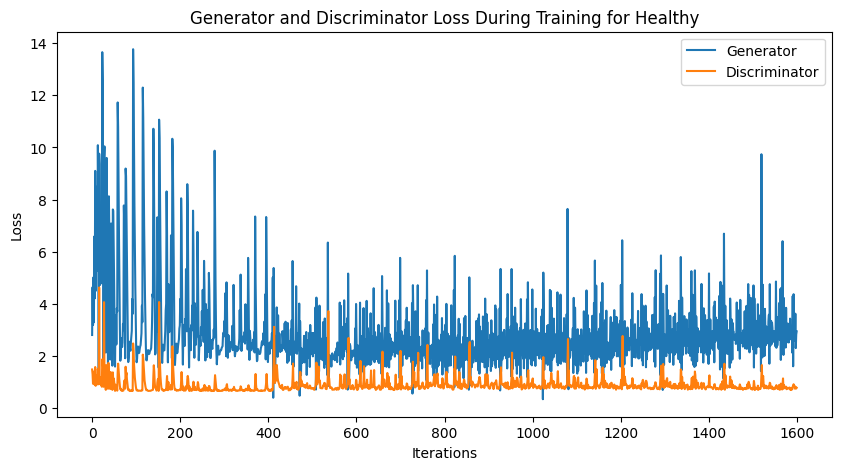

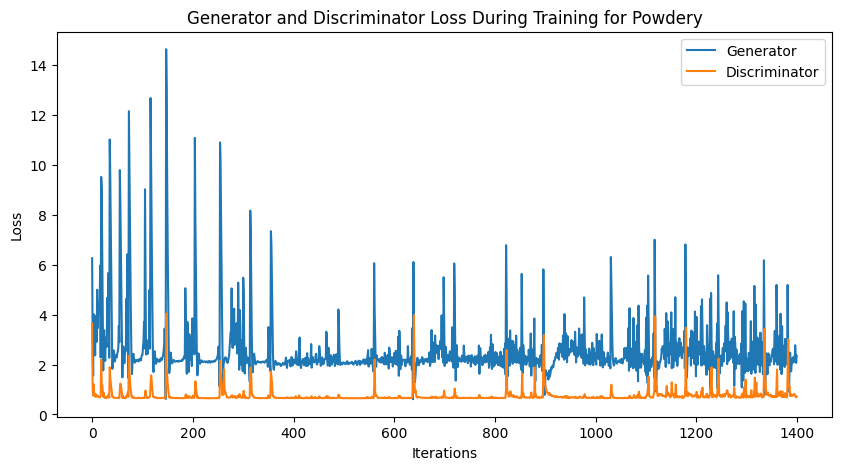

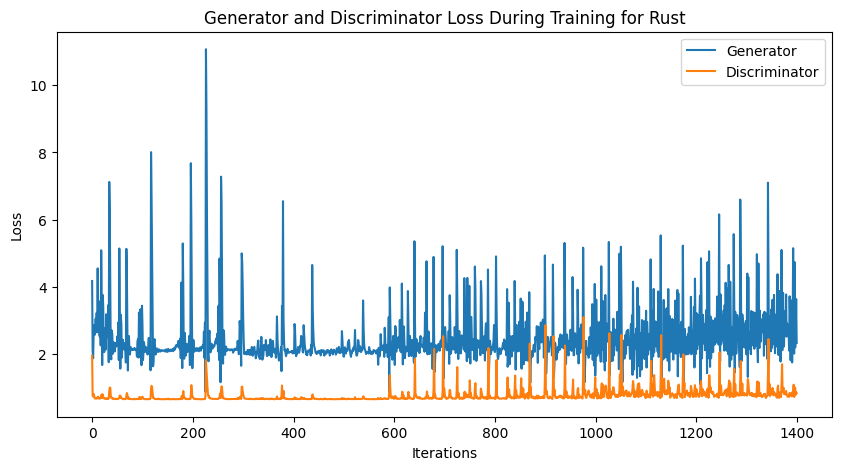

In [6]:
# Plot the training losses for each class
for class_name in classes:
    plt.figure(figsize=(10, 5))
    plt.title(f"Generator and Discriminator Loss During Training for {class_name}")
    plt.plot(losses_G[class_name], label="Generator")
    plt.plot(losses_D[class_name], label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
